<a href="https://colab.research.google.com/github/sathyarajselvaganeshan/COVID-19-Detection-Flask-App-based-on-Chest-X-rays-and-CT-Scans/blob/master/Covid_predicted_with_CT_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/COVID Detection'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/COVID Detection


In [3]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import pandas as pd

print("All libraries are imported")

All libraries are imported


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 500
batch_size = 32

#define paths
covid_path = 'CT_COVID/CT_COVID'
noncovid_path = 'CT_NonCOVID/CT_NonCOVID'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [5]:
# Visualize file variable contents
print("First 5 Covid Files: ",covid_files[0:5])
print("_________________________________________________________________________________________________________________________")
print("Total Count: ",len(covid_files))
print("_________________________________________________________________________________________________________________________")
print("First 5 NonCovid Files: ",noncovid_files[0:5])
print("_________________________________________________________________________________________________________________________")
print("Total Count: ",len(noncovid_files))

First 5 Covid Files:  ['CT_COVID/CT_COVID/2020.02.10.20021584-p6-52%12.png', 'CT_COVID/CT_COVID/2020.02.10.20021584-p6-52%15.png', 'CT_COVID/CT_COVID/2020.01.24.919183-p27-133.png', 'CT_COVID/CT_COVID/2020.01.24.919183-p27-135.png', 'CT_COVID/CT_COVID/2020.02.10.20021584-p6-52%10.png']
_________________________________________________________________________________________________________________________
Total Count:  349
_________________________________________________________________________________________________________________________
First 5 NonCovid Files:  ['CT_NonCOVID/CT_NonCOVID/1059.png', 'CT_NonCOVID/CT_NonCOVID/1050.png', 'CT_NonCOVID/CT_NonCOVID/1%2.jpg', 'CT_NonCOVID/CT_NonCOVID/1049.png', 'CT_NonCOVID/CT_NonCOVID/104.png']
_________________________________________________________________________________________________________________________
Total Count:  397


In [6]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('CT_COVID')
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('CT_NonCOVID')

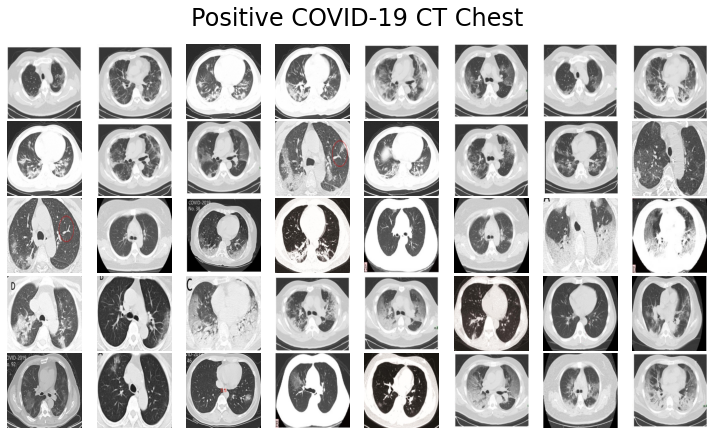

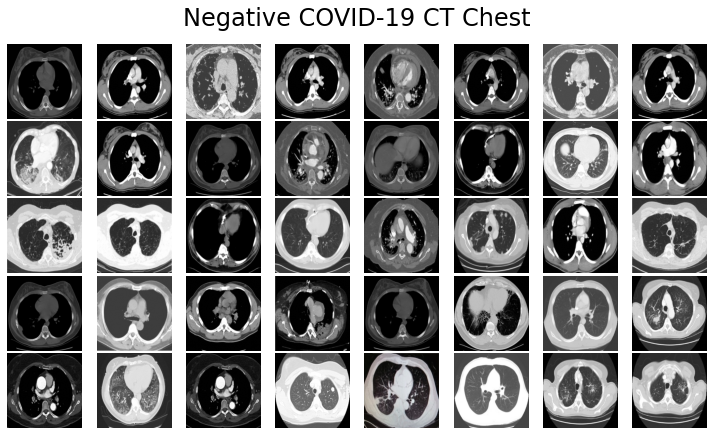

In [44]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 CT Chest')
plot_images(noncovid_images, 'Negative COVID-19 CT Chest')

In [8]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

###Split the dataset into train,test and concatenate the datasets

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

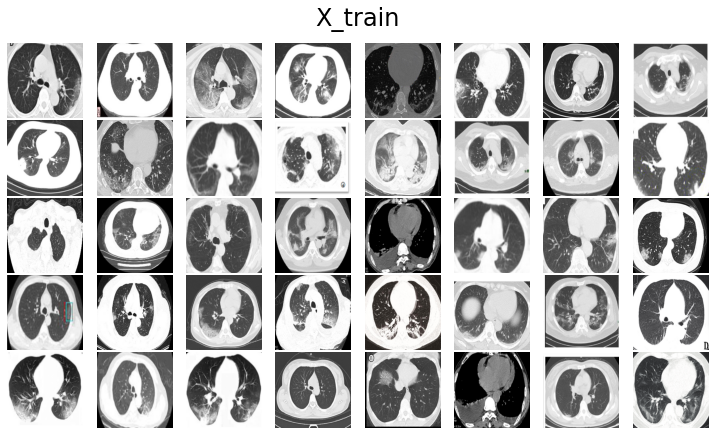

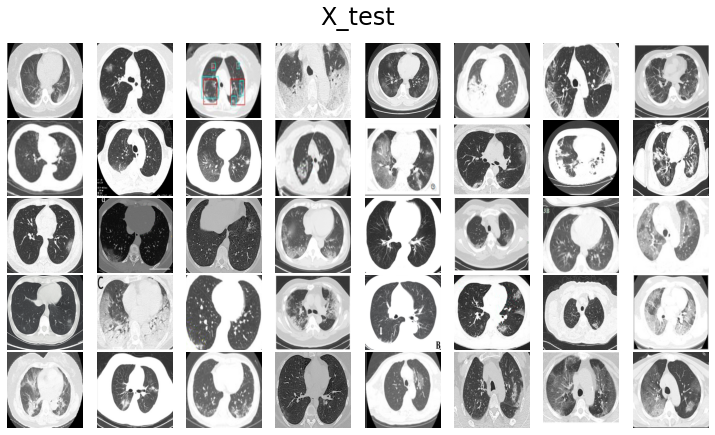

In [10]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

In [11]:
vggModel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

80142336/80134624 [==============================] - 1s 0us/step


In [12]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [13]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [14]:


history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=500)



Epoch 1/500
19/18 [==============================] - 8s 442ms/step - loss: 1.0531 - accuracy: 0.5638 - val_loss: 0.5494 - val_accuracy: 0.7467
Epoch 2/500
19/18 [==============================] - 7s 353ms/step - loss: 0.7045 - accuracy: 0.6661 - val_loss: 0.5042 - val_accuracy: 0.7600
Epoch 3/500
19/18 [==============================] - 7s 351ms/step - loss: 0.6955 - accuracy: 0.6628 - val_loss: 0.6036 - val_accuracy: 0.7467
Epoch 4/500
19/18 [==============================] - 7s 352ms/step - loss: 0.6581 - accuracy: 0.6930 - val_loss: 0.6746 - val_accuracy: 0.7133
Epoch 5/500
19/18 [==============================] - 7s 355ms/step - loss: 0.6097 - accuracy: 0.7114 - val_loss: 0.4434 - val_accuracy: 0.8000
Epoch 6/500
19/18 [==============================] - 7s 354ms/step - loss: 0.5648 - accuracy: 0.7349 - val_loss: 0.5079 - val_accuracy: 0.7467
Epoch 7/500
19/18 [==============================] - 7s 357ms/step - loss: 0.6622 - accuracy: 0.7164 - val_loss: 0.4407 - val_accuracy: 0.8067

In [15]:
model.save('vgg_chest.h5')

In [16]:
model.save_weights('vggweights_chest.hdf5')

In [17]:
model = load_model('vgg_chest.h5')

In [18]:
y_pred = model.predict(X_test, batch_size=batch_size)


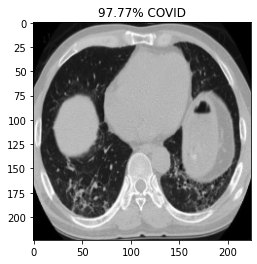

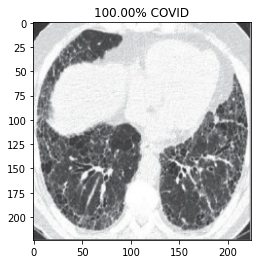

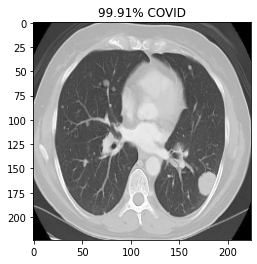

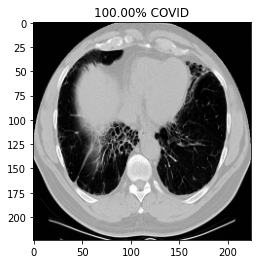

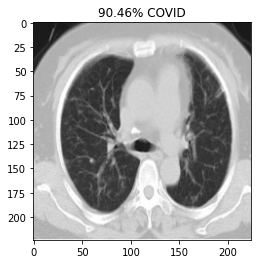

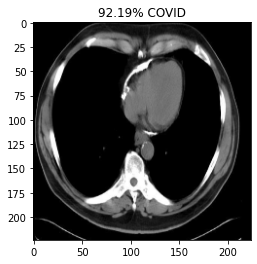

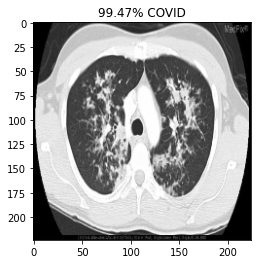

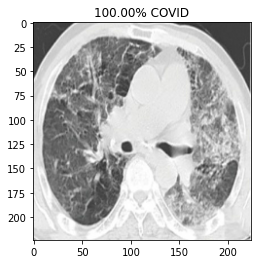

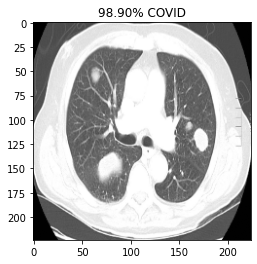

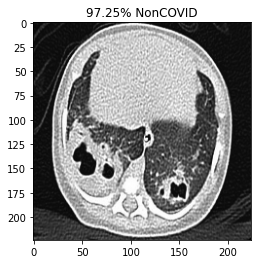

In [19]:


prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()



In [20]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

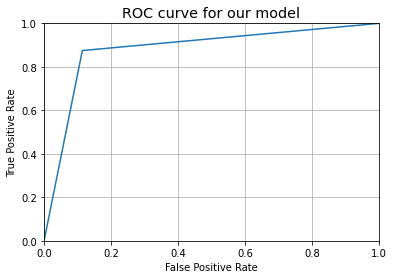

In [21]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


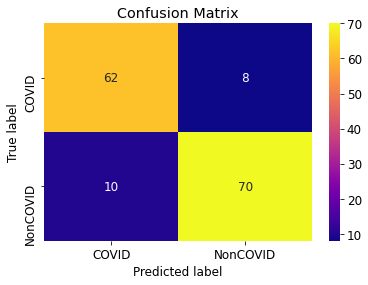

Confusion Matrix with Normalized Values


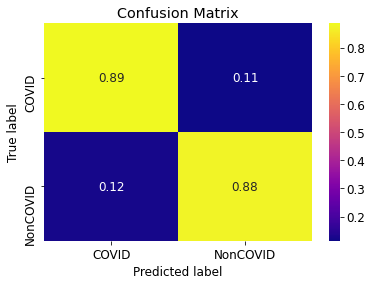

In [22]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))



              precision    recall  f1-score   support

           0       0.86      0.89      0.87        70
           1       0.90      0.88      0.89        80

    accuracy                           0.88       150
   macro avg       0.88      0.88      0.88       150
weighted avg       0.88      0.88      0.88       150



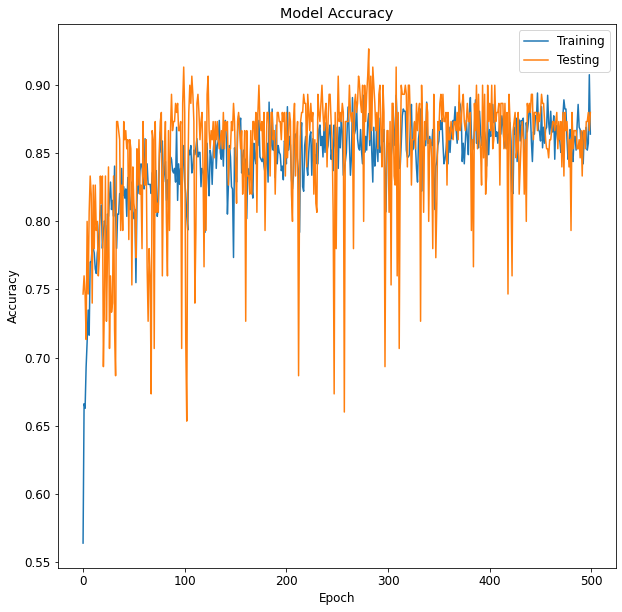

In [24]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_accuracy.png')
plt.show()



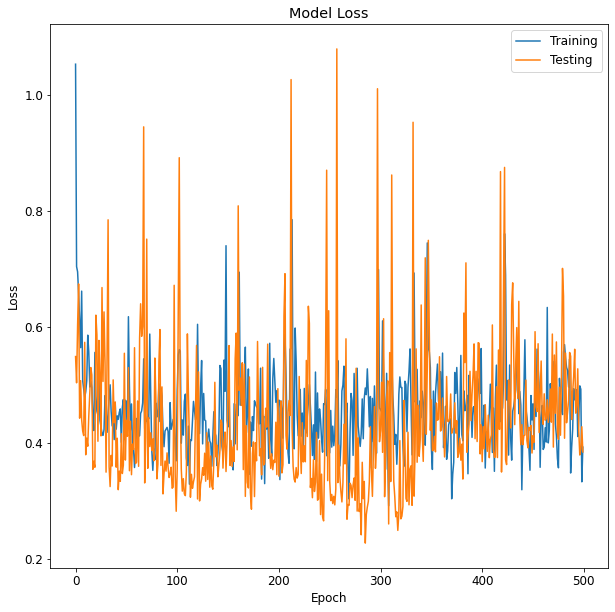

In [25]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_loss.png')
plt.show()


Let's Try algorithm on random image of CT scan. (POSITIVE COVID19)

Patient detail

    COVID-19 pneumonia - lung window
    Age: 75 years
    Gender: male

normal image ref: https://radiopaedia.org/cases/covid-19-pneumonia-12?lang=gb


[[0.4009482  0.59905183]]


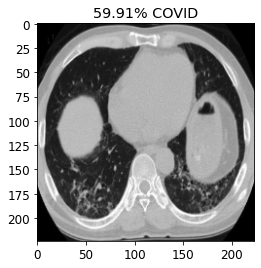

In [46]:
# First try on random positive image Let's see how algorithm works.

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import sys
from PIL import Image

successive_outputs = [layer.output for layer in model.layers[1:]]

visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

img  = cv2.imread('/content/drive/My Drive/COVID Detection/Random sample/sample 1 Covid Positive.jpg')
img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # arrange format as per deep learning libraries
img  = cv2.resize(img,(250,250))                 # resize as per model

x = img_to_array(img)  # Numpy array with shape (250, 250, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 250, 250, 3)

# Rescale by 1/255 
x /= 255

# Make prediction
successive_feature_maps = model.predict(x)
print(successive_feature_maps)

for index, probability in enumerate(successive_feature_maps):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [47]:
pip install flask